# Baseline CNN model



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os
from pathlib import Path


# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.0+cu126
Device: cuda


## Load the dataset

In [4]:
# Load the preprocessed tensors so we can skip the heavy CSV wrangling

dataset_path = Path("/content/drive/MyDrive/data/dataset_challenge_2.pt")

if not dataset_path.exists():
    raise FileNotFoundError(
        f"dataset.pt not found"
    )

try:
    bundle = torch.load(dataset_path, map_location="cpu")
except RuntimeError as err:
        raise


X_train = bundle["X_train"].clone().detach().float()
y_train = bundle["y_train"].clone().detach().view(-1).long()
X_val = bundle["X_val"].clone().detach().float()
y_val = bundle["y_val"].clone().detach().view(-1).long()
X_test = bundle["X_test"].clone().detach().float()



print(f"Train tensor shape: {tuple(X_train.shape)}")
print(f"Validation tensor shape: {tuple(X_val.shape)}")
print(f"Test tensor shape: {tuple(X_test.shape)}")


Train tensor shape: (1270, 128, 128, 3)
Validation tensor shape: (142, 128, 128, 3)
Test tensor shape: (954, 128, 128, 3)


In [5]:
BATCH_SIZE = 64
EVAL_BATCH_SIZE = 128


def make_loader(dataset, batch_size, shuffle, drop_last):
    """Wrap tensors in a DataLoader."""
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,
    )

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test)

train_loader = make_loader(train_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = make_loader(val_ds, EVAL_BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = make_loader(test_ds, EVAL_BATCH_SIZE, shuffle=False, drop_last=False)


# Handy metadata for configuring the model
input_size = X_train.shape[1:]
num_classes = len(torch.unique(y_train))
print(f"Input size: {input_size}, classes: {num_classes}")


Input size: torch.Size([128, 128, 3]), classes: 4


In [6]:
# Fetch a batch to capture the per-sample input shape for summaries
for xb, yb in train_loader:
    input_shape = xb.shape[1:]
    num_classes = len(np.unique(yb.cpu().numpy()))
    break

print(f"Input shape per sample: {input_shape}")


Input shape per sample: torch.Size([128, 128, 3])


## CNN class

In [7]:
# Single convolutional block with multiple conv layers, ReLU and pooling/stride
class VanillaCNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs=1, use_stride=False, stride_value=2, padding_size=1, pool_size=2):
        super().__init__()

        layers = []

        # First convolution: in_channels -> out_channels
        if num_convs == 1:
            # Single conv: apply stride here if use_stride is True
            stride = stride_value if use_stride else 1
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding_size, stride=stride))
        else:
            # Multiple convs: first one always has stride=1
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1))

            # Intermediate convolutions (all with stride=1)
            for i in range(1, num_convs - 1):
                layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1))

            # Last convolution: apply stride here if use_stride is True
            stride = stride_value if use_stride else 1
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding_size, stride=stride))

        # ReLU activation
        layers.append(nn.ReLU())

        # Pooling only if not using stride for spatial reduction
        if not use_stride:
            layers.append(nn.MaxPool2d(kernel_size=pool_size, stride=pool_size))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

# Convolutional Neural Network architecture for image classification
class CNN(nn.Module):
    def __init__(self, input_shape=(3,32,32), num_classes=10, dropout_rate=0.2,
                 num_blocks=2, convs_per_block=1,
                 use_stride=False, stride_value=2, padding_size=1, pool_size=2,
                 initial_channels=32, channel_multiplier=2):
        super().__init__()

        # Build convolutional blocks
        blocks = []
        in_channels = input_shape[0]
        out_channels = initial_channels

        for i in range(num_blocks):
            blocks.append(VanillaCNNBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                num_convs=convs_per_block,
                use_stride=use_stride,
                stride_value=stride_value,
                padding_size=padding_size,
                pool_size=pool_size
            ))

            # Prepare for next block: increase channels
            in_channels = out_channels
            out_channels = out_channels * channel_multiplier

        self.features = nn.Sequential(*blocks)

        # Calculate flattened size after all blocks using a dummy forward pass
        # This approach is robust and works with any configuration of padding, stride, and pooling
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]

        # Classification head: flatten features and apply dropout before final layer
        self.classifier_head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(flattened_size, num_classes)
        )

    # Forward pass through the network
    def forward(self, x):
        x = self.features(x)
        x = self.classifier_head(x)
        return x

## training and evaluating functions

In [8]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # permute inputs (batch, channel, height, width)
        inputs = inputs.permute(0, 3, 1, 2)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [9]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # permute inputs (batch, channel, height, width)
            inputs = inputs.permute(0, 3, 1, 2)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [10]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)


        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

## Hyperparameters

In [11]:
# Number of training epochs
LEARNING_RATE = 1e-3
EPOCHS = 1000
PATIENCE = 50

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rare:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

Epochs: 1000
Batch Size: 64
Learning Rare: 0.001
Dropout Rate: 0.2
L1 Penalty: 0
L2 Penalty: 0


In [12]:
# CNN Architecture parameters
# Number of convolutional blocks
NUM_BLOCKS = 2

# Number of conv layers per block
CONVS_PER_BLOCK = 1

# Use strided convolutions instead of pooling
USE_STRIDE = False

# Stride value when USE_STRIDE is True
STRIDE_VALUE = 2

# Padding size
PADDING_SIZE = 1

# Pooling size when USE_STRIDE is False
POOL_SIZE = 2

# Number of channels in first block
INITIAL_CHANNELS = 32

# Channel multiplication factor between blocks
CHANNEL_MULTIPLIER = 2

print("Num Blocks:", NUM_BLOCKS)
print("Convs per Block:", CONVS_PER_BLOCK)
print("Use Stride:", USE_STRIDE)
print("Stride Value:", STRIDE_VALUE)
print("Padding Size:", PADDING_SIZE)
print("Pool Size:", POOL_SIZE)
print("Initial Channels:", INITIAL_CHANNELS)
print("Channel Multiplier:", CHANNEL_MULTIPLIER)

Num Blocks: 2
Convs per Block: 1
Use Stride: False
Stride Value: 2
Padding Size: 1
Pool Size: 2
Initial Channels: 32
Channel Multiplier: 2


## Training

In [13]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [14]:
# Instantiate CNN model and move to computing device (CPU/GPU)

# Reorder input_shape from (H, W, C) to (C, H, W) for PyTorch Conv2d layers
input_shape_chw = (input_shape[2], input_shape[0], input_shape[1])

cnn_model = CNN(
    input_shape_chw,
    num_classes,
    num_blocks=NUM_BLOCKS,
    convs_per_block=CONVS_PER_BLOCK,
    use_stride=USE_STRIDE,
    stride_value=STRIDE_VALUE,
    padding_size=PADDING_SIZE,
    pool_size=POOL_SIZE,
    initial_channels=INITIAL_CHANNELS,
    channel_multiplier=CHANNEL_MULTIPLIER
    ).to(device)

# Display model architecture summary
summary(cnn_model, input_size=input_shape_chw)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
   VanillaCNNBlock-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
              ReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
   VanillaCNNBlock-8           [-1, 64, 32, 32]               0
           Flatten-9                [-1, 65536]               0
          Dropout-10                [-1, 65536]               0
           Linear-11                    [-1, 4]         262,148
Total params: 281,540
Trainable params: 281,540
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/

In [15]:
# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [16]:
experiment_name = "cnn_baseline_1"

writer = SummaryWriter(f"./{logs_dir}/cnn")


# %%time
# Train model and track training history
cnn_model, training_history = fit(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name=experiment_name,
    patience=20
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = cnn_model
    best_performance = training_history['val_f1'][-1]

Training 1000 epochs...
Epoch   1/1000 | Train: Loss=1.4760, F1 Score=0.2941 | Val: Loss=1.3005, F1 Score=0.2688
Epoch   2/1000 | Train: Loss=1.2475, F1 Score=0.3506 | Val: Loss=1.3046, F1 Score=0.3399
Epoch   3/1000 | Train: Loss=1.2015, F1 Score=0.3589 | Val: Loss=1.2588, F1 Score=0.3304
Epoch   4/1000 | Train: Loss=1.1703, F1 Score=0.3689 | Val: Loss=1.2787, F1 Score=0.3395


KeyboardInterrupt: 

## Evaluation

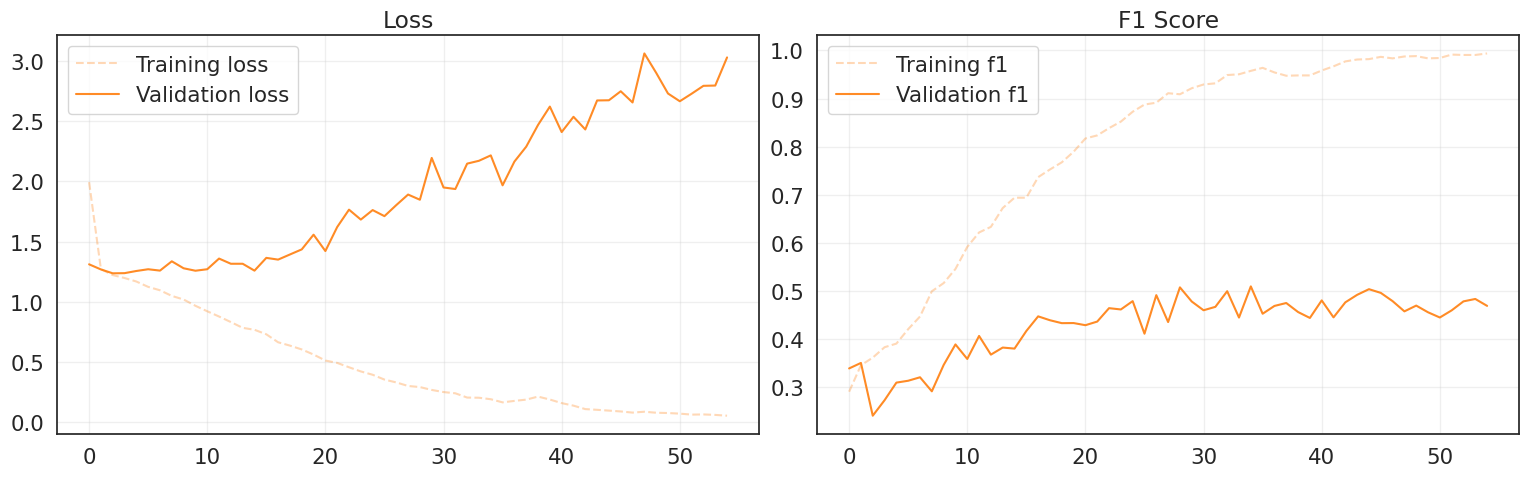

In [21]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.5211
Precision over the validation set: 0.5104
Recall over the validation set: 0.5211
F1 score over the validation set: 0.5099


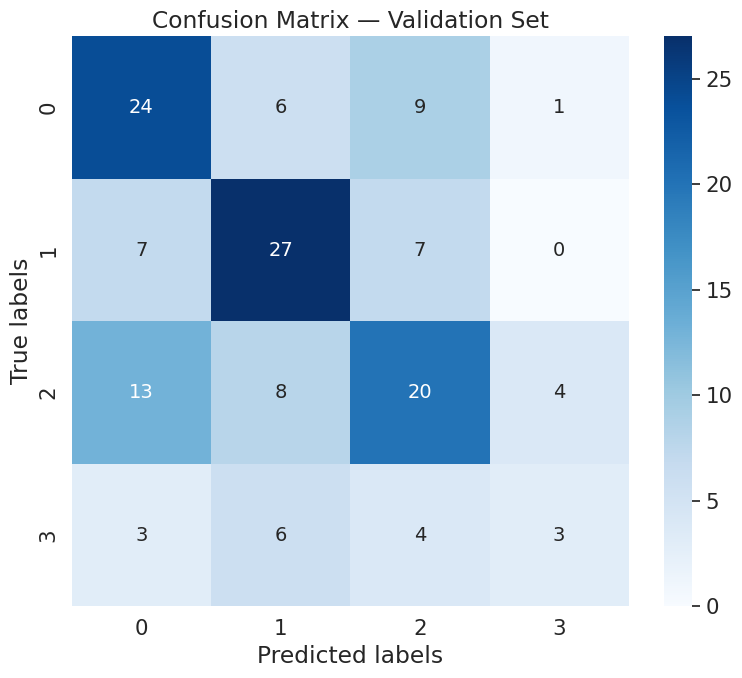

In [23]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)
        # Permute dimensions from (batch_size, height, width, channels) to (batch_size, channels, height, width)
        xb = xb.permute(0, 3, 1, 2)

        # Forward pass: get model predictions
        logits = cnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [21]:
# ----------------------------
# Hyperparameter search space
# ----------------------------

def grid_search(
    param_grid,
    input_shape,
    num_classes,
    train_loader,
    val_loader,
    criterion,
    device,
    base_config=None,
    max_epochs=100,
    patience=15,
    weight_decay=0.0,
    verbose=1,
    save_path="models/best_cnn_grid_search.pt"
):
    """
    Performs grid search over hyperparameters for the CNN model.

    param_grid: dict of lists
    base_config: optional dictionary of CNN parameters to keep fixed
    """

    import itertools
    import copy

    # Expand hyperparameter grid
    all_configs = list(itertools.product(*param_grid.values()))
    print(f"\nTotal configurations: {len(all_configs)}\n")

    results = []
    best_score = -float("inf")
    best_params = None
    best_model_state = None

    # Training loop over all combinations
    for config in all_configs:
        hparams = dict(zip(param_grid.keys(), config))

        # Merge with fixed parameters (if provided)
        if base_config:
            full_params = {**base_config, **hparams}
        else:
            full_params = hparams

        print("\n========================================")
        print("Testing configuration:", full_params)
        print("========================================")

        input_shape_chw = (input_shape[2], input_shape[0], input_shape[1])

        # Build model using supplied parameters
        model = CNN(
            input_shape=input_shape_chw,
            num_classes=num_classes,
            num_blocks=full_params["num_blocks"],
            convs_per_block=full_params["convs_per_block"],
            initial_channels=full_params["initial_channels"],
            channel_multiplier=full_params["channel_multiplier"],
            dropout_rate=full_params["dropout_rate"],
            use_stride=full_params["use_stride"],
            stride_value=full_params["stride_value"],
            padding_size=full_params["padding_size"],
            pool_size=full_params["pool_size"],
        ).to(device)

        # Optimizer
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=full_params["lr"],
            weight_decay=weight_decay
        )

        # AMP scaler
        scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Train model
        model, history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=max_epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=scaler,
            device=device,
            patience=patience,
            experiment_name="grid_temp",
            verbose=0,
        )

        # Score to compare models
        val_f1 = np.max(history["val_f1"])
        print(f" → F1 Score: {val_f1:.4f}")

        # Save results
        row = full_params.copy()
        row["val_f1"] = val_f1
        results.append(row)

        # Track best model
        if val_f1 > best_score:
            best_score = val_f1
            best_params = full_params.copy()
            best_model_state = copy.deepcopy(model.state_dict())

        # Free GPU memory
        del model
        torch.cuda.empty_cache()

    # Save best model
    torch.save(best_model_state, save_path)

    print("\n========================")
    print("Best hyperparameters:")
    print(best_params)
    print("Best F1:", best_score)
    print("========================")

    # Return results as DataFrame
    return pd.DataFrame(results), best_params, best_score


In [22]:
param_grid = {
    "num_blocks":        [1, 2, 3],
    "convs_per_block":   [1, 2],
    "initial_channels":  [16, 32],
    "channel_multiplier":[2],
    "dropout_rate":      [0.0, 0.2, 0.4],
    "lr":                [1e-3, 5e-4, 1e-4],
}

# Fixed parameters (architecture options you don't want to grid-search)
base_config = {
    "use_stride": USE_STRIDE,
    "stride_value": STRIDE_VALUE,
    "padding_size": PADDING_SIZE,
    "pool_size": POOL_SIZE,
}

df_results, best_params, best_score = grid_search(
    param_grid=param_grid,
    input_shape=input_shape,
    num_classes=num_classes,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device=device,
    base_config=base_config,
    weight_decay=L2_LAMBDA,
    max_epochs=100,
    patience=15,
    save_path="models/best_cnn_grid_search.pt"
)



Total configurations: 108


Testing configuration: {'use_stride': False, 'stride_value': 2, 'padding_size': 1, 'pool_size': 2, 'num_blocks': 1, 'convs_per_block': 1, 'initial_channels': 16, 'channel_multiplier': 2, 'dropout_rate': 0.0, 'lr': 0.001}
Training 100 epochs...


Exception ignored in: <function _releaseLock at 0x7f77267f5760>
Traceback (most recent call last):
  File "/usr/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 23986) exited unexpectedly

In [ ]:
df_results

## Inference

In [ ]:
cnn_model = best_model

In [26]:
# Collect predictions and ground truth labels
list_preds = []
list_idx = []
with torch.no_grad():  # Disable gradient computation for inference
    for batch_idx, (xb,) in enumerate(test_loader):
        xb = xb.to(device) # Unpack the tensor from the list

        # permute inputs
        xb = xb.permute(0, 3, 1, 2)

        # Forward pass: get model predictions
        logits = cnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        list_preds.append(preds)

        # Calculate the actual sample indices for this batch
        start_index = batch_idx * EVAL_BATCH_SIZE
        current_batch_size = len(preds) # Use len(preds) to handle the last batch possibly being smaller
        batch_sample_indices = np.arange(start_index, start_index + current_batch_size)
        list_idx.append(batch_sample_indices)

# Combine all batches into single arrays
list_preds = np.concatenate(list_preds)
list_idx = np.concatenate(list_idx)

# Create a DataFrame for the predictions
df_preds = pd.DataFrame({"sample_index": list_idx, "label": list_preds})

In [28]:
# mapping labels
mapping = {0: 'Luminal A',
             1: 'Luminal B',
             2: 'HER2(+)',
             3: 'Triple negative'}

df_preds['label'] = df_preds['label'].map(mapping)
df_preds["sample_index"] = df_preds["sample_index"].apply(lambda x: f"img_{int(x):04d}.png")

In [30]:
df_preds.to_csv('predictions.csv', index=False, header=True)